# Package a MobileNetV2 machine learning model with dependencies

When deploying a custom machine learning model for inference on Greengrass, 3 components are required to be deployed on the device:

- the machine learning model itself
- machine learning libraries, which can load the model for inference, e.g. Tensorflow, Pytorch or [SageMaker Neo DLR](https://github.com/neo-ai/neo-ai-dlr)
- inference business logic usually written as a lambda function in a programming language like Python

Either the machine learning model or the libraries can exceed the maximum size limit of 50 MB of lambda functions fairly quickly. To ensure they can still be deployed using the standard Greengrass deployment process, you can package them using [machine learning resources](https://docs.aws.amazon.com/greengrass/latest/developerguide/access-ml-resources.html)

This notebook saves a standard pretrained MobileNetV2 model using Keras. It then creates a tar archive of the model, its dependencies like Tensorflow and its labels. This archive can then be loaded by Greengrass as machine learning resource for deployment.For a real world use case we would [fine-tune](https://www.tensorflow.org/tutorials/images/transfer_learning) the pretrained model based on custom images and labels for our business problem.

Keep in mind that below steps should be automated on a device running the same hardware and software configuration as the Greengrass device. This is due to the fact that machine leanring libraries are usually hardware dependent eg. CPU vs GPU. 

## Download the model

In [29]:
#BUCKET = '<your_bucket_name>''
BUCKET = 'ml-gg-deployment-sample'

In [30]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
import PIL.Image as Image
import urllib.request, json 

In [31]:
IMG_SIZE = 224
IMAGE_SHAPE = (IMG_SIZE,IMG_SIZE,3)
classifier = tf.keras.applications.MobileNetV2(input_shape=IMAGE_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

## Download labels

In [32]:
urllib.request.urlretrieve("https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt", "labels.txt")
with open('labels.txt', 'r') as file:
    labels_txt = file.read()
labels = labels_txt.split("\n")
# remove background class which is not used by this model
labels = labels[1:]

## Test the model inference

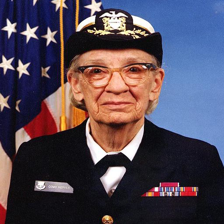

In [33]:
urllib.request.urlretrieve("https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg", "image.jpg")
grace_hopper = Image.open("image.jpg").resize((IMG_SIZE,IMG_SIZE))
grace_hopper


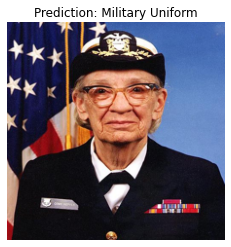

In [34]:
# Normalize values for preprocessing
grace_hopper = np.array(grace_hopper)/255.0
# call model for inference
result = classifier.predict(grace_hopper[np.newaxis, ...])
predicted_class = np.argmax(result[0], axis=-1)
# plot result
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Save the model

The model will be saved in [Tensorflow Saved model](https://www.tensorflow.org/guide/saved_model) format!

In [35]:
classifier.save("saved_model")

INFO:tensorflow:Assets written to: saved_model/assets


# Build dependencies and upload

In [36]:
# Download labels
!curl https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt -O
# Download dependencies
!pip3 install tensorflow -t dependencies

# Create a tar ball of model, dependencies and labels
!rm -rf model_package && mkdir -p model_package
!mv saved_model ImageNetLabels.txt dependencies model_package
!tar -zcf model-package.tar.gz -C model_package .

# upload to S3
!aws s3 cp model-package.tar.gz "s3://$BUCKET/models/mobilenet-keras-with-libs/model-package.tar.gz"
!echo "Uploaded final package to s3://$BUCKET/models/mobilenet-keras-with-libs/model-package.tar.gz"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10484  100 10484    0     0   602k      0 --:--:-- --:--:-- --:--:--  602k
  Using cached tensorflow-2.3.0-cp36-cp36m-manylinux2010_x86_64.whl (320.4 MB)
  Using cached absl_py-0.10.0-py3-none-any.whl (127 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
Processing /home/ec2-user/.cache/pip/wheels/93/2a/eb/e58dbcbc963549ee4f065ff80a59f274cc7210b6eab962acdc/termcolor-1.1.0-py3-none-any.whl
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached numpy-1.18.5-cp36-cp36m-manylinux1_x86_64.whl (20.1 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached tensorflow_estimator-2.3.0-py2.py3-none-any.whl (459 kB)
  Using cached wheel-0.35.1-py2.py3-none-any.